In [1]:
import qiskit.tools.jupyter
%qiskit_version_table

In [2]:
%matplotlib inline

import numpy as np
from math import sqrt, pi
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit import ParameterVector


from qiskit_ibm_provider import IBMProvider

from qiskit_aer import AerSimulator, StatevectorSimulator
# The IBM Quantum Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler, Estimator, Session, Options

In [3]:
from qiskit_ibm_provider import IBMProvider

IBMProvider.save_account(token='8ed60a4497b9aa57767dfcbf689fb1b4a6bc6ce97a8d37f3eb06047ea4ee1f4fec011631e45ab0d9bd8888dee14f844c6b67a46f6a857b0b283630c6ecc0ea89', overwrite = True)


provider = IBMProvider()

provider.backends()

backend_perth = provider.get_backend('ibm_perth')
backend_lima = provider.get_backend('ibmq_lima')

In [4]:
backend = provider.get_backend('ibm_canberra')

In [5]:
backend

<IBMBackend('ibm_canberra')>

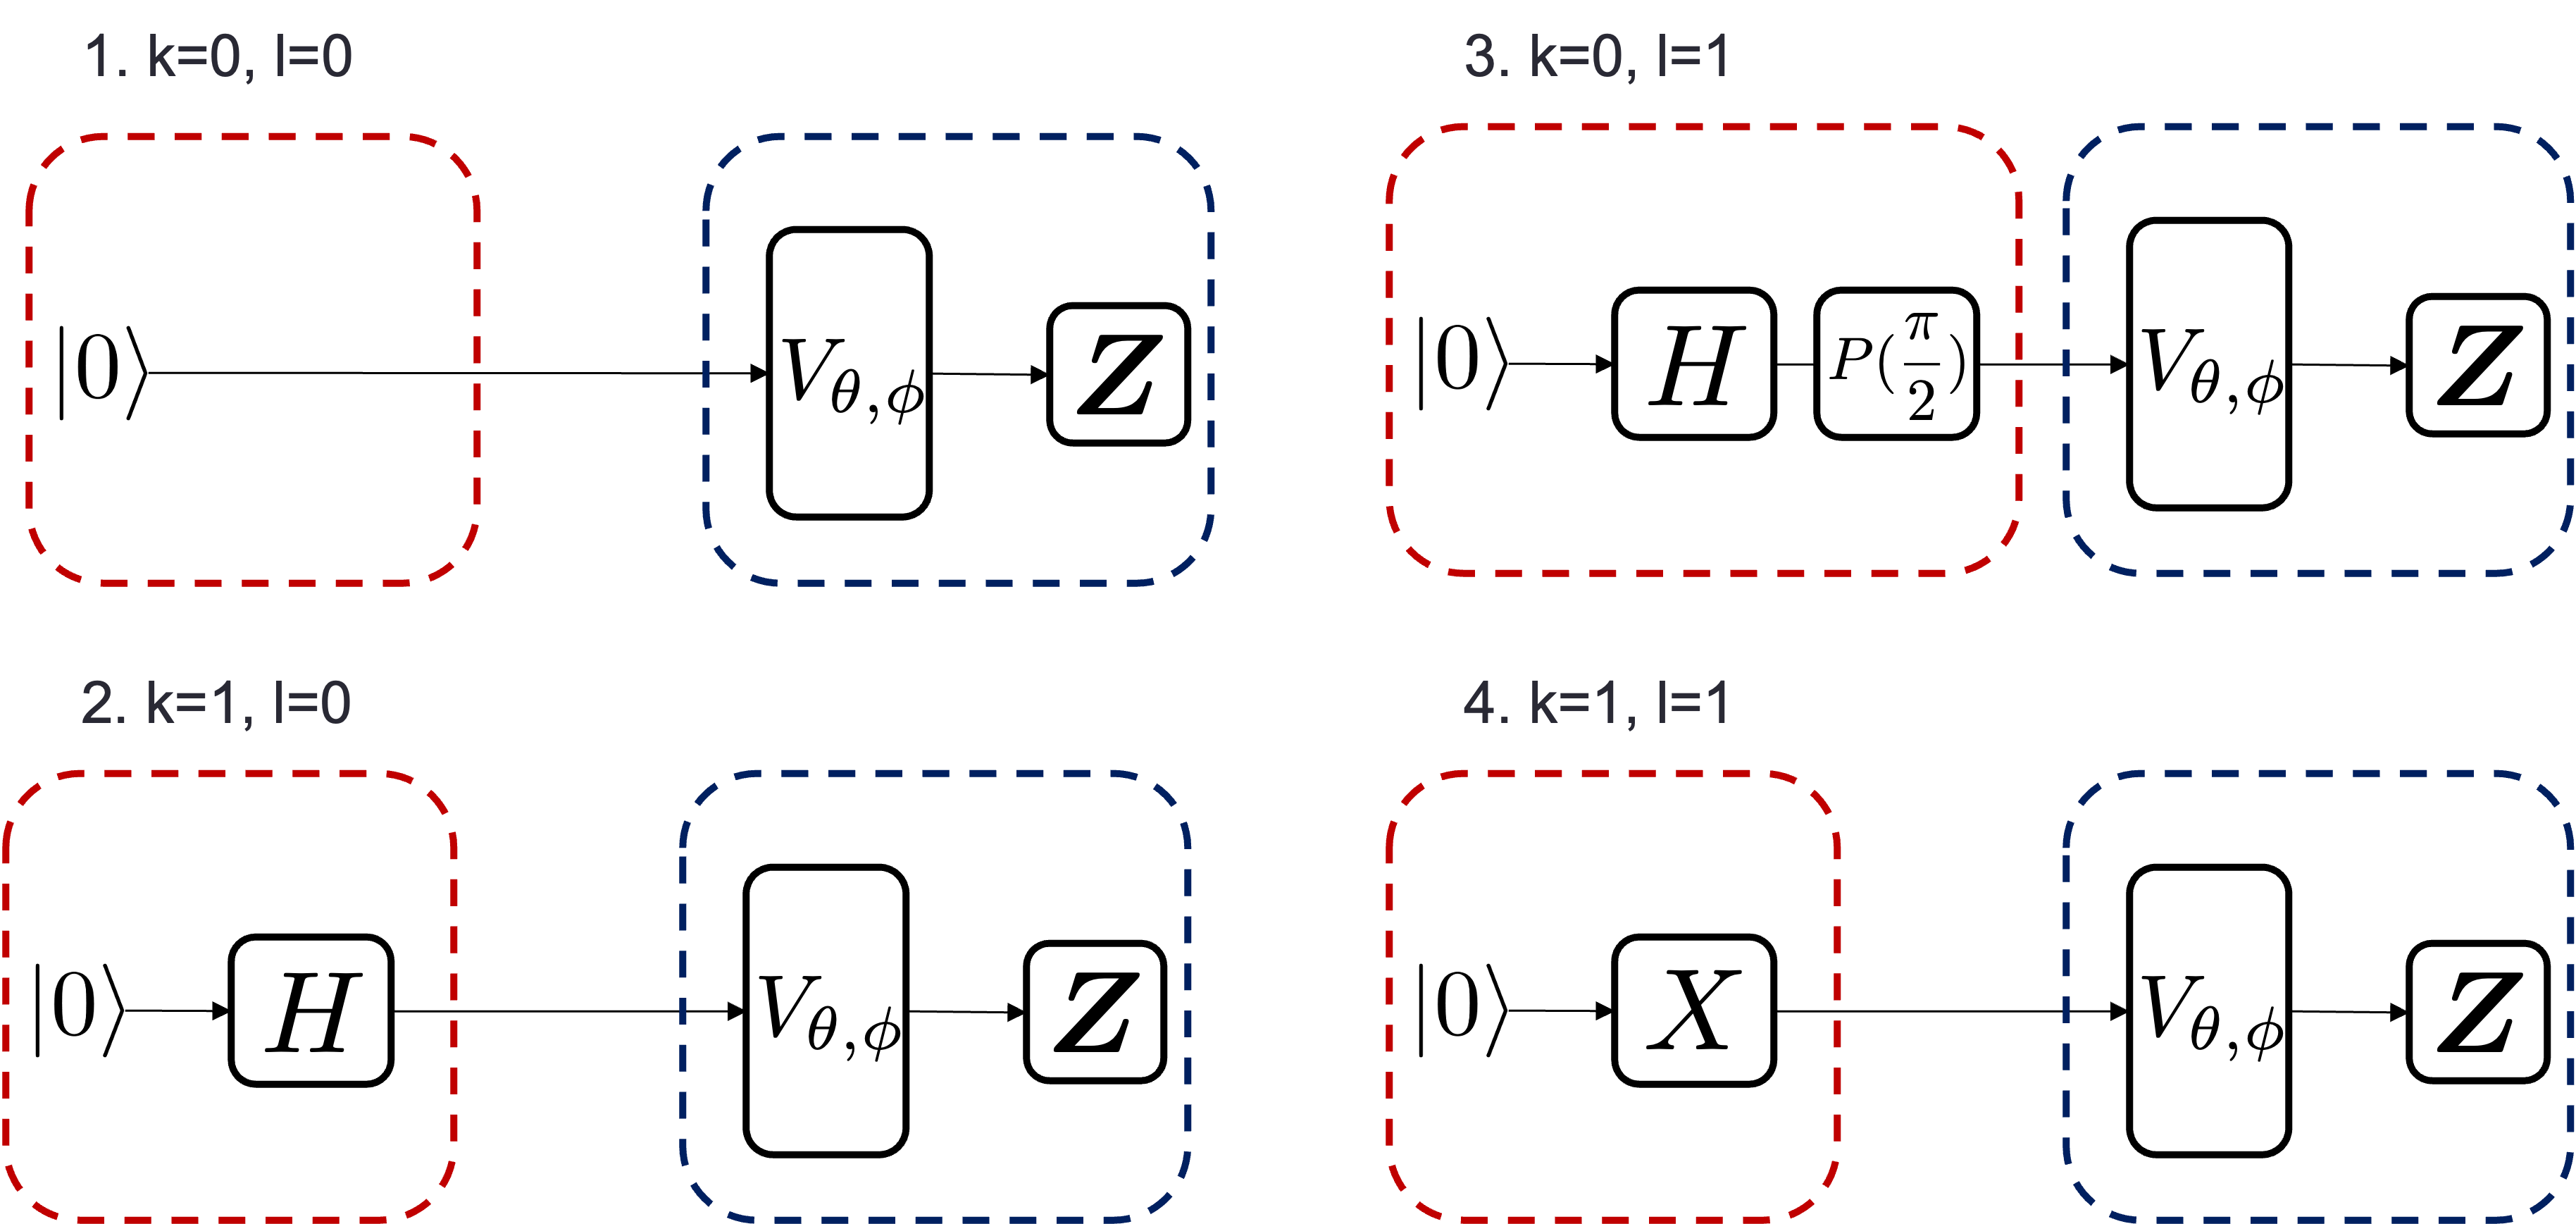

#### Quantum circuit for estimating coherence of measurements

In [6]:
#Generate tomo circuit by using parameterized circuit

def d_tomo_circ():
    
    circuit = []
    
    # define your parameters
    p = ParameterVector('p', 2)  
    
    for i in range(4):
        
        if i==0:
            qc = QuantumCircuit(1)
            
            qc.barrier()
            
            qc.rz(-p[1], 0)
            qc.ry(-p[0], 0)
            qc.measure_all()
            circuit.append(qc)
            
        elif i==1:
            qc = QuantumCircuit(1)
            
            #State preperation
            qc.h(0)
            
            qc.barrier()
            
            #Measurement
            qc.rz(-p[1], 0)
            qc.ry(-p[0], 0)
            qc.measure_all()
            circuit.append(qc)
            
        elif i==2:
            qc = QuantumCircuit(1)
            
            #State preperation
            qc.h(0)
            qc.p(np.pi/2,0)
            
            qc.barrier()
            
            #measurement
            qc.rz(-p[1], 0)
            qc.ry(-p[0], 0)
            qc.measure_all()
            circuit.append(qc)
        
        else:
            qc = QuantumCircuit(1)
            
            #State preperation
            qc.x(0)
            
            qc.barrier()
            
            #measurement
            qc.rz(-p[1], 0)
            qc.ry(-p[0], 0)
            qc.measure_all()
            circuit.append(qc)
    
    return(circuit)

In [7]:
#bring tomo_circ
circ = d_tomo_circ()


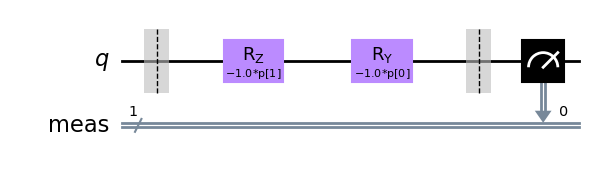

In [8]:
circ[0].draw('mpl')

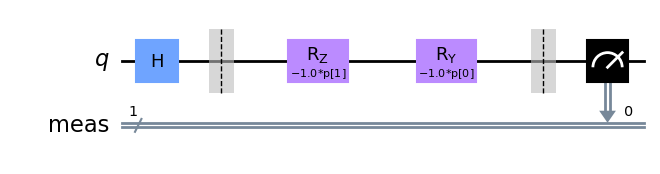

In [9]:
circ[1].draw('mpl')

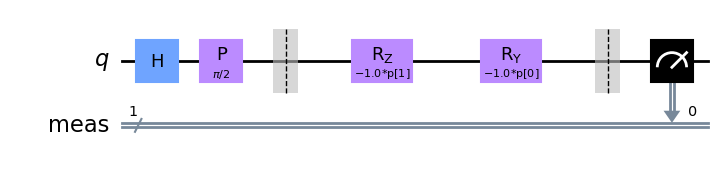

In [10]:
circ[2].draw('mpl')

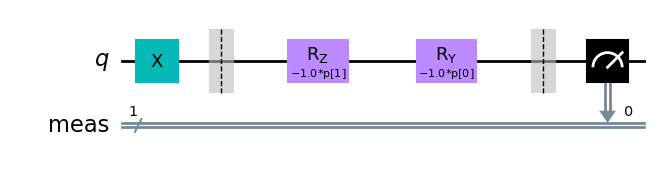

In [11]:
circ[3].draw('mpl')

#### Obtain coutns by local simulator

In [12]:
#bring tomo_circ
circ = d_tomo_circ()

#set-up variable range
theta_range = np.linspace(0, 2 * np.pi - np.pi/8, 16)

#loop theta value
    #loop tomo circ circ 0 ~ 3 with same theta value
circuits = [qc.bind_parameters([np.pi/2, phi])
            for phi in theta_range for qc in circ]

backend = AerSimulator()

counts = backend.run(transpile(circuits, backend), shots=100000).result().get_counts()

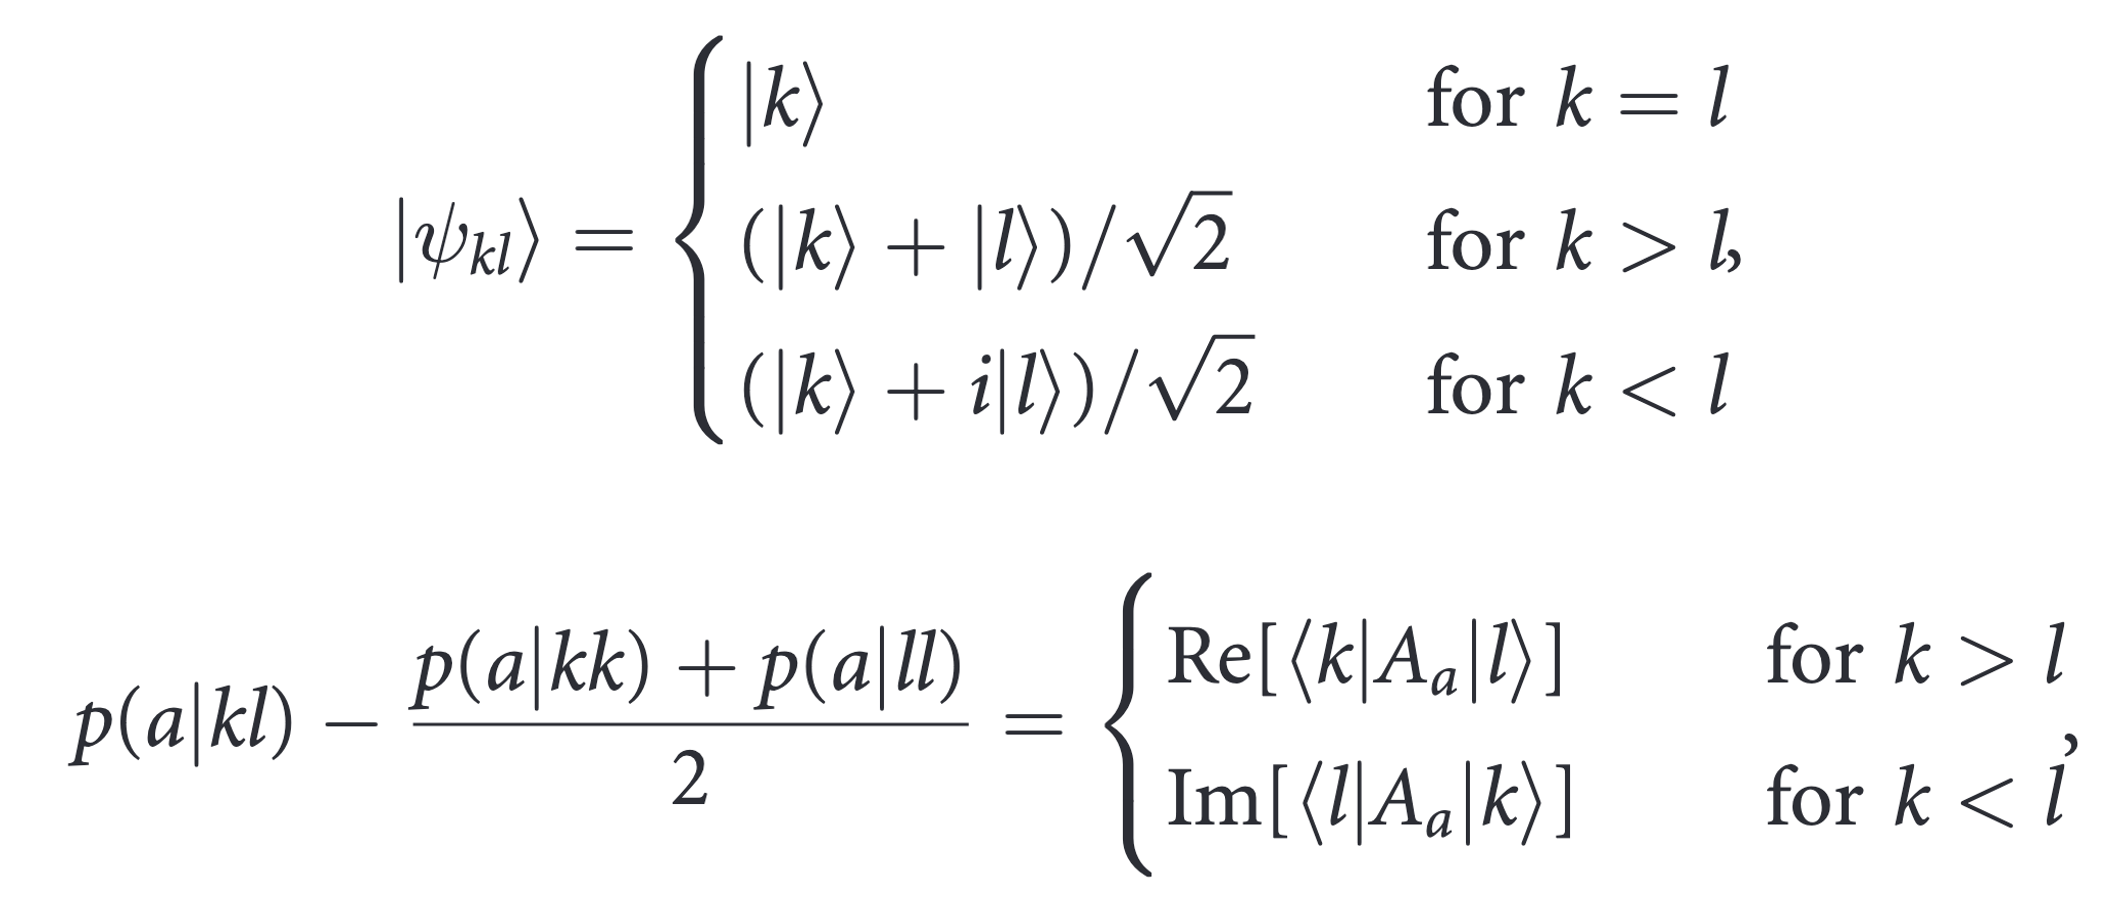

$$M_1 = \begin{pmatrix} p(0|00) & p(0|01) \\ p(0|10) & p(0|11) \end{pmatrix}$$

#### Converts Counts to probability

In [13]:
#return_probabilities
import copy

def prob_data(dic):
    #to avoid changes in original counts
    buf = copy.deepcopy(dic)
    for i in range(len(buf)):
        if '0' not in buf[i].int_outcomes():
            buf[i].setdefault('0', 0)
        if '1' not in buf[i].int_outcomes():
            buf[i].setdefault('1', 0)
        buf[i].update({'0': float(int(buf[i].get('0'))/100000), '1': float(int(buf[i].get('1'))/100000)})
        #print(counts)
    return(buf)

In [14]:
    #converts counts to prob
prob = prob_data(counts)
    
    #slice probabilities into 4 in one
prob = [prob[i:i+4] for i in range(0, len(prob),4)]

#### Convert probability to POVM

In [15]:

def det_tomo_POVM0(data): #data is probability #POVM obtained from an experiment result
    l=len(data) #4
    key=['0','1']
    POVM=[]
    key_POVM=['00','01r','01i','11']
    
    for i in range(len(key)):
        x={}
        x[key_POVM[0]]=data[0][key[i]]
        x[key_POVM[1]]=data[1][key[i]]-(data[0][key[i]]+data[3][key[i]])/2
        x[key_POVM[2]]=data[2][key[i]]-(data[0][key[i]]+data[3][key[i]])/2
        x[key_POVM[3]]=data[3][key[i]]
        POVM.append(x)
    return(POVM)


#### Average and Statistical deviation

In [16]:
def ave(POVM):
    x=[]
    key_POVM=['00','01r','01i','11']
    
    for outcome in range(2):
        y={}
        for a in range(4):
            average= POVM[outcome][key_POVM[a]]
            y[key_POVM[a]]=average
        x.append(y)
    
    return(x)

def sta_dis(POVM):
    l=len(POVM)
    x=[]
    key_POVM=['00','01r','01i','11']
    
    for outcome in range(2):
        y={}
        for a in range(4):
            st= POVM[outcome][key_POVM[a]]**2 - ave(POVM)[outcome][key_POVM[a]]**2
            y[key_POVM[a]]=st
        x.append(y)
        
    return(x)

#### Calculate average values and statistical deviation

In [17]:
l=16
average_total=[]
sd_total=[]
for i in range(l):
    average_total.append(ave(det_tomo_POVM0(prob[i])))

#len(average_total)
for i in range(l):
    sd_total.append(sta_dis(det_tomo_POVM0(prob[i])))

In [18]:
key_POVM=['00','01r','01i','11']
data4=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(average_total[j][0][key_POVM[i]])
    
    data4.append(y)

In [19]:
key_POVM=['00','01r','01i','11']
data_sd4=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(sd_total[j][0][key_POVM[i]])
    
    data_sd4.append(y)

#### Plot POVM elements against $\phi$

#### POVM element $M_0$

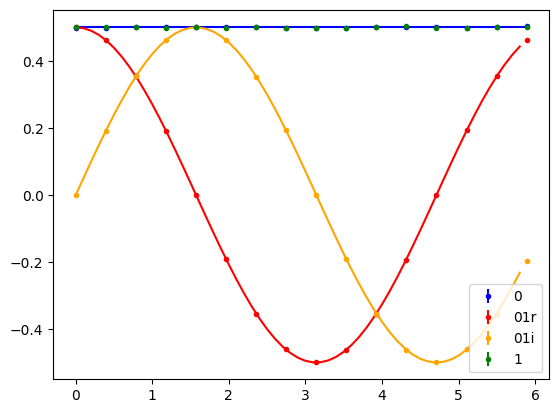

In [20]:
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure()
#x-axis
x = np.arange(0,2*np.pi,np.pi/8)
x0 = np.arange(0,2*np.pi-np.pi/8,0.1)


#y-axis
y = data4

#for i in range(16):
#    y[2][i]=-y[2][i]

yerr = data_sd4

#color
col=['blue','red','orange','green']
#label
lab=['0','01r','01i','1']

for i in range(4):
    plt.errorbar(x, y[i] , yerr=yerr[i], label=lab[i], fmt='.',color=col[i])
    

plt.plot(x, 0*x + 0.5, color=col[0])
plt.plot(x0, 0.5*np.cos(x0), color=col[1])
plt.plot(x0, 0.5*np.sin(x0), color=col[2])



plt.legend(loc='lower right')

#### POVM element $M_1$

In [21]:
key_POVM=['00','01r','01i','11']
data4_1=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(average_total[j][1][key_POVM[i]])
    
    data4_1.append(y)

In [22]:
key_POVM=['00','01r','01i','11']
data_sd4_1=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(sd_total[j][1][key_POVM[i]])
    
    data_sd4_1.append(y)

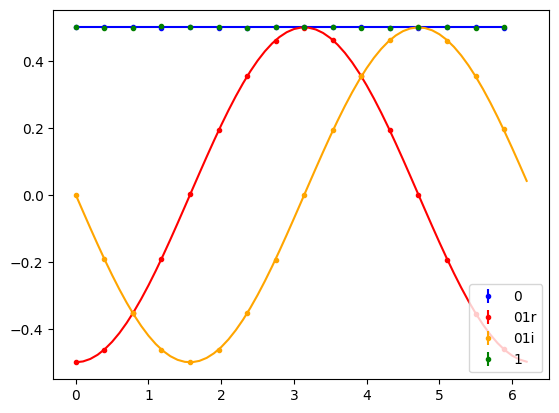

In [23]:
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure()
#x-axis
x = np.arange(0,2*np.pi,np.pi/8)
x0 = np.arange(0,2*np.pi,0.1)


#y-axis
y = data4_1

#for i in range(16):
#    y[2][i]=-y[2][i]

yerr = data_sd4_1

#color
col=['blue','red','orange','green']
#label
lab=['0','01r','01i','1']

for i in range(4):
    plt.errorbar(x, y[i] , yerr=yerr[i], label=lab[i], fmt='.',color=col[i])
    

plt.plot(x, 0*x+0.5, color=col[0])
plt.plot(x0, -0.5*np.cos(x0), color=col[1])
plt.plot(x0, -0.5*np.sin(x0), color=col[2])



plt.legend(loc='lower right')

# Real Backend Experiment


## $\theta=\pi/2$ and  $\phi=0,\pi/8,\pi/4,...,15\pi/6$
Each job is excuted with 100000 shots

In [18]:
#수업을 위해 추가된 허브와 그룹, 프로젝트를 프로바이더에 설정
IBMProvider.save_account("", overwrite=True)
#provider = IBMProvider()

from qiskit_ibm_provider import IBMProvider

provider = IBMProvider(instance="ibm-q-yonsei/externalq-meetup/tutorials")

In [28]:
provider.backends() #5 7Q Backends

[<IBMBackend('ibmq_quito')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('ibmq_guadalupe')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_canberra')>]

In [20]:
from qiskit_ibm_provider import least_busy

#real_backend = least_busy(provider.backends())

#real_backend
real_backend = provider.get_backend('ibm_nairobi')

In [29]:
#bring tomo_circ
circ = d_tomo_circ()

#set-up variable range
theta_range = np.linspace(0, 2 * np.pi - np.pi/8, 16)

#loop theta value
    #loop tomo circ circ 0 ~ 3 with same theta value
circuits = [qc.bind_parameters([np.pi/2, phi])
            for phi in theta_range for qc in circ]

# backend = AerSimulator()
backend = provider.get_backend('ibm_nairobi')

counts = backend.run(transpile(circuits, backend), shots=100000).result().get_counts()

In [90]:
job_retrieve = provider.backend.retrieve_job('cibhccp02cefj75cv9q0')
results = job_retrieve.result()

In [96]:
counts_1 = results.get_counts()

In [97]:
print(counts_1)

[{'0': 50179, '1': 49821}, {'0': 98821, '1': 1179}, {'0': 51652, '1': 48348}, {'0': 49853, '1': 50147}, {'0': 50304, '1': 49696}, {'0': 95111, '1': 4889}, {'0': 69666, '1': 30334}, {'0': 50359, '1': 49641}, {'0': 50153, '1': 49847}, {'0': 84611, '1': 15389}, {'0': 85077, '1': 14923}, {'0': 50365, '1': 49635}, {'0': 50537, '1': 49463}, {'0': 69328, '1': 30672}, {'0': 95260, '1': 4740}, {'0': 50935, '1': 49065}, {'0': 50902, '1': 49098}, {'0': 50816, '1': 49184}, {'0': 98907, '1': 1093}, {'0': 51410, '1': 48590}, {'0': 51314, '1': 48686}, {'0': 32699, '1': 67301}, {'0': 95019, '1': 4981}, {'0': 52259, '1': 47741}, {'0': 51996, '1': 48004}, {'0': 17295, '1': 82705}, {'0': 84799, '1': 15201}, {'0': 52859, '1': 47141}, {'0': 52356, '1': 47644}, {'0': 7271, '1': 92729}, {'0': 68998, '1': 31002}, {'0': 52839, '1': 47161}, {'0': 52137, '1': 47863}, {'0': 3654, '1': 96346}, {'0': 50742, '1': 49258}, {'0': 52988, '1': 47012}, {'0': 52465, '1': 47535}, {'0': 7343, '1': 92657}, {'0': 32701, '1': 6

In [98]:
    #converts counts to prob
prob = prob_data(counts_1)
    
    #slice probabilities into 4 in one
prob = [prob[i:i+4] for i in range(0, len(prob),4)]

In [99]:
l=16
average_total_1=[]
sd_total_1=[]
for i in range(l):
    average_total_1.append(ave(det_tomo_POVM0(prob[i])))

#len(average_total)
for i in range(l):
    sd_total_1.append(sta_dis(det_tomo_POVM0(prob[i])))

In [100]:
key_POVM=['00','01r','01i','11']
data1=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(average_total_1[j][0][key_POVM[i]])
    
    data1.append(y)

In [101]:
key_POVM=['00','01r','01i','11']
data_sd1=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(sd_total[j][0][key_POVM[i]])
    
    data_sd1.append(y)

Text(0.5, 1.0, '(a) $M_0$ for $\\theta=\\pi/2$')

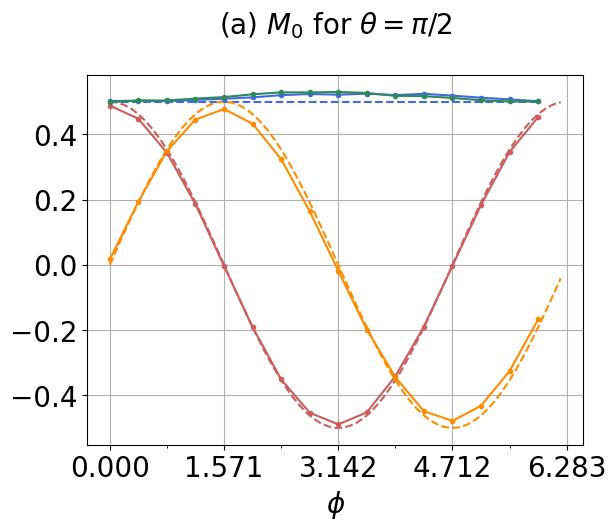

In [102]:
fig, ax = plt.subplots()

#x-axis
x = np.arange(0,2*np.pi,np.pi/8)
x0 = np.arange(0,2*np.pi,0.1)


#y-axis
y = data1

#for i in range(16):
#    y[2][i]=-y[2][i]

yerr = data_sd1

#color
col=['royalblue','indianred','darkorange','seagreen']
#label
lab=[r'$\langle 0| M_0 |0\rangle  $',r'Re$[\langle 0| M_0 |1\rangle]$',r'Im$[\langle 0| M_0 |1\rangle]$',r'$\langle 1| M_0 |1\rangle$']


for i in range(4):
    plt.errorbar(x, y[i] , yerr=yerr[i], label=lab[i], fmt='.',color=col[i])
    
ax.plot(x, 0*x+0.5,'--', color=col[0])
ax.plot(x0, 0.5*np.cos(x0),'--', color=col[1])
ax.plot(x0, 0.5*np.sin(x0),'--', color=col[2])

ax.plot(x, y[0], color=col[0])
ax.plot(x, y[1], color=col[1])
ax.plot(x, y[2], color=col[2])
ax.plot(x, y[3], color=col[3])

plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)

ax.grid(True)
# ax.legend(frameon=False)
# ax.axis('equal')
# ax.set_xlim(0, 2 * np.pi);
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
# ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax.set_xlabel(r'$\phi$',fontsize=20)
ax.set_title(r'(a) $M_0$ for $\theta=\pi/2$',fontsize=20,pad=30)

#plt.legend(loc='lower right')

#### POVM element $M_1$

In [103]:
key_POVM=['00','01r','01i','11']
data1_1=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(average_total_1[j][1][key_POVM[i]])
    
    data1_1.append(y)

In [104]:
key_POVM=['00','01r','01i','11']
data_sd_1_1=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(sd_total_1[j][1][key_POVM[i]])
    
    data_sd_1_1.append(y)

Text(0.5, 1.0, '(b) $M_1$ for $\\theta=\\pi/2$')

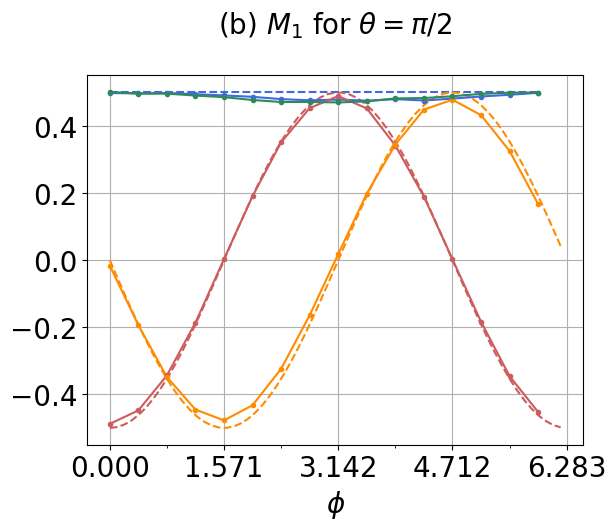

In [107]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
#x-axis
x = np.arange(0,2*np.pi,np.pi/8)
x0 = np.arange(0,2*np.pi,0.1)


#y-axis
y = data1_1

#for i in range(16):
#    y[2][i]=-y[2][i]

yerr = data_sd_1_1

#color
col=['royalblue','indianred','darkorange','seagreen']
#label
lab=[r'$\langle 0| M_0 |0\rangle  $',r'Re$[\langle 0| M_0 |1\rangle]$',r'Im$[\langle 0| M_0 |1\rangle]$',r'$\langle 1| M_0 |1\rangle$']



for i in range(4):
    plt.errorbar(x, y[i] , yerr=yerr[i], label=lab[i], fmt='.',color=col[i])
    

plt.plot(x, 0*x+0.5,'--', color=col[0])
plt.plot(x0, -0.5*np.cos(x0),'--', color=col[1])
plt.plot(x0, -0.5*np.sin(x0),'--', color=col[2])

plt.plot(x, y[0], color=col[0])
plt.plot(x, y[1], color=col[1])
plt.plot(x, y[2], color=col[2])
plt.plot(x, y[3], color=col[3])

plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)

ax.grid(True)
#ax.legend(frameon=False)
# ax.axis('equal')
# ax.set_xlim(0, 2 * np.pi);
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
# ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax.set_xlabel(r'$\phi$',fontsize=20)
ax.set_title(r'(b) $M_1$ for $\theta=\pi/2$',fontsize=20,pad=30)

#plt.legend(loc='lower right')

# Real Backend Experiment


## $\theta=\pi/4$ and  $\phi=0,\pi/8,\pi/4,...,15\pi/6$
Each job is excuted with 100000 shots

In [18]:
#수업을 위해 추가된 허브와 그룹, 프로젝트를 프로바이더에 설정
IBMProvider.save_account("", overwrite=True)
#provider = IBMProvider()

from qiskit_ibm_provider import IBMProvider

provider = IBMProvider(instance="ibm-q-yonsei/externalq-meetup/tutorials")

In [28]:
provider.backends() #5 7Q Backends

[<IBMBackend('ibmq_quito')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('ibmq_guadalupe')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_canberra')>]

In [20]:
from qiskit_ibm_provider import least_busy

#real_backend = least_busy(provider.backends())

#real_backend
real_backend = provider.get_backend('ibm_nairobi')

In [44]:
#bring tomo_circ
circ = d_tomo_circ()

#set-up variable range
theta_range = np.linspace(0, 2 * np.pi - np.pi/8, 16)

#loop theta value
    #loop tomo circ circ 0 ~ 3 with same theta value
circuits = [qc.bind_parameters([np.pi/4, phi])
            for phi in theta_range for qc in circ]

# backend = AerSimulator()
backend = provider.get_backend('ibm_nairobi')

counts = backend.run(transpile(circuits, backend), shots=100000).result().get_counts()

KeyboardInterrupt: 

In [ ]:
print(counts)

In [ ]:
counts = 

In [110]:
job_retrieve = provider.backend.retrieve_job('cibi1pk8lm446nsibjbg')
results = job_retrieve.result()

In [112]:
counts_2 = results.get_counts()

In [113]:
print(counts_2)

[{'0': 83599, '1': 16401}, {'0': 84887, '1': 15113}, {'0': 50843, '1': 49157}, {'0': 17607, '1': 82393}, {'0': 84377, '1': 15623}, {'0': 81326, '1': 18674}, {'0': 63681, '1': 36319}, {'0': 17009, '1': 82991}, {'0': 84436, '1': 15564}, {'0': 74223, '1': 25777}, {'0': 74293, '1': 25707}, {'0': 17218, '1': 82782}, {'0': 84650, '1': 15350}, {'0': 63751, '1': 36249}, {'0': 81605, '1': 18395}, {'0': 17629, '1': 82371}, {'0': 84765, '1': 15235}, {'0': 50650, '1': 49350}, {'0': 83939, '1': 16061}, {'0': 17604, '1': 82396}, {'0': 85121, '1': 14879}, {'0': 37963, '1': 62037}, {'0': 81393, '1': 18607}, {'0': 18293, '1': 81707}, {'0': 85563, '1': 14437}, {'0': 27571, '1': 72429}, {'0': 74288, '1': 25712}, {'0': 18401, '1': 81599}, {'0': 85740, '1': 14260}, {'0': 20148, '1': 79852}, {'0': 63741, '1': 36259}, {'0': 18655, '1': 81345}, {'0': 86098, '1': 13902}, {'0': 17834, '1': 82166}, {'0': 50568, '1': 49432}, {'0': 18379, '1': 81621}, {'0': 85932, '1': 14068}, {'0': 20413, '1': 79587}, {'0': 38074

In [114]:
    #converts counts to prob
prob = prob_data(counts_2)
    
    #slice probabilities into 4 in one
prob = [prob[i:i+4] for i in range(0, len(prob),4)]

In [115]:
l=16
average_total_2=[]
sd_total_2=[]
for i in range(l):
    average_total_2.append(ave(det_tomo_POVM0(prob[i])))

#len(average_total)
for i in range(l):
    sd_total_2.append(sta_dis(det_tomo_POVM0(prob[i])))

In [116]:
key_POVM=['00','01r','01i','11']
data2=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(average_total_2[j][0][key_POVM[i]])
    
    data2.append(y)

In [117]:
key_POVM=['00','01r','01i','11']
data_sd_2=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(sd_total[j][0][key_POVM[i]])
    
    data_sd_2.append(y)

Text(0.5, 1.0, '(c) $M_0$ for $\\theta=\\pi/4$')

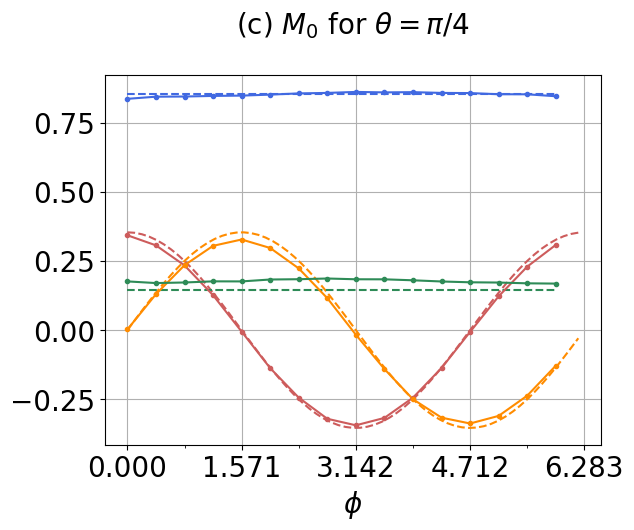

In [118]:
fig, ax = plt.subplots()

#x-axis
x = np.arange(0,2*np.pi,np.pi/8)
x0 = np.arange(0,2*np.pi,0.1)


#y-axis
y = data2

#for i in range(16):
#    y[2][i]=-y[2][i]

yerr = data_sd_2

#color
col=['royalblue','indianred','darkorange','seagreen']
#label
lab=[r'$\langle 0| M_0 |0\rangle  $',r'Re$[\langle 0| M_0 |1\rangle]$',r'Im$[\langle 0| M_0 |1\rangle]$',r'$\langle 1| M_0 |1\rangle$']


for i in range(4):
    plt.errorbar(x, y[i] , yerr=yerr[i], label=lab[i], fmt='.',color=col[i])
    
plt.plot(x, 0*x+np.cos(np.pi/8)**2,'--', color=col[0])
plt.plot(x0, np.cos(np.pi/8)*np.sin(np.pi/8)*np.cos(x0),'--', color=col[1])
plt.plot(x0, np.cos(np.pi/8)*np.sin(np.pi/8)*np.sin(x0),'--', color=col[2])
plt.plot(x, 0*x+np.sin(np.pi/8)**2,'--', color=col[3])


ax.plot(x, y[0], color=col[0])
ax.plot(x, y[1], color=col[1])
ax.plot(x, y[2], color=col[2])
ax.plot(x, y[3], color=col[3])

plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)

ax.grid(True)
# ax.legend(frameon=False)
# ax.axis('equal')
# ax.set_xlim(0, 2 * np.pi);
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
# ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax.set_xlabel(r'$\phi$',fontsize=20)
ax.set_title(r'(c) $M_0$ for $\theta=\pi/4$',fontsize=20,pad=30)
#plt.legend(loc='lower right')

#### POVM element $M_1$

In [119]:
key_POVM=['00','01r','01i','11']
data2_1=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(average_total_2[j][1][key_POVM[i]])
    
    data2_1.append(y)

In [120]:
key_POVM=['00','01r','01i','11']
data_sd_2_1=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(sd_total_2[j][1][key_POVM[i]])
    
    data_sd_2_1.append(y)

Text(0.5, 1.0, '(d) $M_1$ for $\\theta=\\pi/4$')

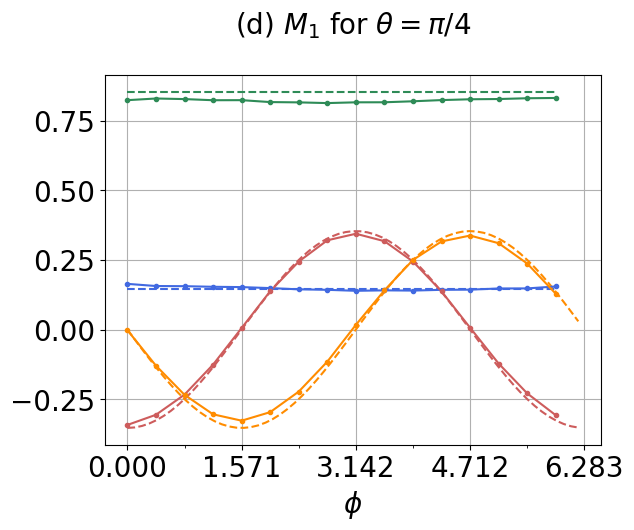

In [121]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
#x-axis
x = np.arange(0,2*np.pi,np.pi/8)
x0 = np.arange(0,2*np.pi,0.1)


#y-axis
y = data2_1

#for i in range(16):
#    y[2][i]=-y[2][i]

yerr = data_sd_2_1

#color
col=['royalblue','indianred','darkorange','seagreen']
#label
lab=[r'$\langle 0| M_0 |0\rangle  $',r'Re$[\langle 0| M_0 |1\rangle]$',r'Im$[\langle 0| M_0 |1\rangle]$',r'$\langle 1| M_0 |1\rangle$']



for i in range(4):
    plt.errorbar(x, y[i] , yerr=yerr[i], label=lab[i], fmt='.',color=col[i])
    

plt.plot(x,0*x+np.sin(np.pi/8)**2 ,'--', color=col[0])
plt.plot(x0, -np.cos(np.pi/8)*np.sin(np.pi/8)*np.cos(x0),'--', color=col[1])
plt.plot(x0, -np.cos(np.pi/8)*np.sin(np.pi/8)*np.sin(x0),'--', color=col[2])
plt.plot(x, 0*x+np.cos(np.pi/8)**2,'--', color=col[3])

plt.plot(x, y[0], color=col[0])
plt.plot(x, y[1], color=col[1])
plt.plot(x, y[2], color=col[2])
plt.plot(x, y[3], color=col[3])

plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)

ax.grid(True)
#ax.legend(frameon=False)
# ax.axis('equal')
# ax.set_xlim(0, 2 * np.pi);
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
# ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax.set_xlabel(r'$\phi$',fontsize=20)
ax.set_title(r'(d) $M_1$ for $\theta=\pi/4$',fontsize=20,pad=30)

# plt.legend(loc='lower right')

# Real Backend Experiment


## $\theta=0,\pi/8,\pi/4,...,15\pi/6$ and  $\phi=0$
Each job is excuted with 100000 shots

In [18]:
#수업을 위해 추가된 허브와 그룹, 프로젝트를 프로바이더에 설정
IBMProvider.save_account("", overwrite=True)
#provider = IBMProvider()

from qiskit_ibm_provider import IBMProvider

provider = IBMProvider(instance="ibm-q-yonsei/externalq-meetup/tutorials")

In [28]:
provider.backends() #5 7Q Backends

[<IBMBackend('ibmq_quito')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('ibmq_guadalupe')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_canberra')>]

In [20]:
from qiskit_ibm_provider import least_busy

#real_backend = least_busy(provider.backends())

#real_backend
real_backend = provider.get_backend('ibm_nairobi')

In [44]:
#bring tomo_circ
circ = d_tomo_circ()

#set-up variable range
theta_range = np.linspace(0, 2 * np.pi - np.pi/8, 16)

#loop theta value
    #loop tomo circ circ 0 ~ 3 with same theta value
circuits = [qc.bind_parameters([np.pi/4, phi])
            for phi in theta_range for qc in circ]

# backend = AerSimulator()
backend = provider.get_backend('ibm_nairobi')

counts = backend.run(transpile(circuits, backend), shots=100000).result().get_counts()

KeyboardInterrupt: 

In [122]:
job_retrieve = provider.backend.retrieve_job('ciboa7h61rck8jtk60rg')
results = job_retrieve.result()

In [123]:
counts_3 = results.get_counts()

In [124]:
print(counts_3)

[{'0': 98758, '1': 1242}, {'0': 50546, '1': 49454}, {'0': 50115, '1': 49885}, {'0': 4073, '1': 95927}, {'0': 94360, '1': 5640}, {'0': 69244, '1': 30756}, {'0': 50648, '1': 49352}, {'0': 7569, '1': 92431}, {'0': 83237, '1': 16763}, {'0': 84621, '1': 15379}, {'0': 50733, '1': 49267}, {'0': 17738, '1': 82262}, {'0': 67572, '1': 32428}, {'0': 95234, '1': 4766}, {'0': 51453, '1': 48547}, {'0': 33009, '1': 66991}, {'0': 50446, '1': 49554}, {'0': 98765, '1': 1235}, {'0': 51731, '1': 48269}, {'0': 50165, '1': 49835}, {'0': 31508, '1': 68492}, {'0': 95217, '1': 4783}, {'0': 52289, '1': 47711}, {'0': 69021, '1': 30979}, {'0': 16697, '1': 83303}, {'0': 85237, '1': 14763}, {'0': 52410, '1': 47590}, {'0': 84448, '1': 15552}, {'0': 7072, '1': 92928}, {'0': 69794, '1': 30206}, {'0': 52592, '1': 47408}, {'0': 94940, '1': 5060}, {'0': 4108, '1': 95892}, {'0': 52332, '1': 47668}, {'0': 52711, '1': 47289}, {'0': 98814, '1': 1186}, {'0': 7780, '1': 92220}, {'0': 34774, '1': 65226}, {'0': 52350, '1': 47650

In [125]:
    #converts counts to prob
prob = prob_data(counts_3)
    
    #slice probabilities into 4 in one
prob = [prob[i:i+4] for i in range(0, len(prob),4)]

In [126]:
l=16
average_total_3=[]
sd_total_3=[]
for i in range(l):
    average_total_3.append(ave(det_tomo_POVM0(prob[i])))

#len(average_total)
for i in range(l):
    sd_total_3.append(sta_dis(det_tomo_POVM0(prob[i])))

In [127]:
key_POVM=['00','01r','01i','11']
data3=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(average_total_3[j][0][key_POVM[i]])
    
    data3.append(y)

In [128]:
key_POVM=['00','01r','01i','11']
data_sd_3=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(sd_total_3[j][0][key_POVM[i]])
    
    data_sd_3.append(y)

Text(0.5, 1.0, '(e) $M_0$ for $\\phi=0$')

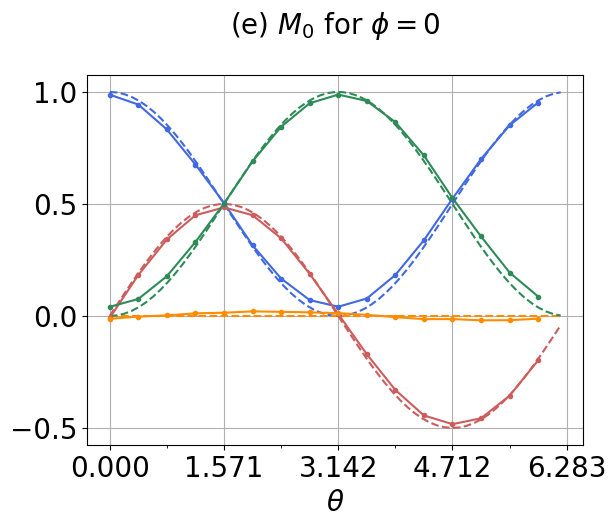

In [129]:
fig, ax = plt.subplots()

#x-axis
x = np.arange(0,2*np.pi,np.pi/8)
x0 = np.arange(0,2*np.pi,0.1)


#y-axis
y = data3

#for i in range(16):
#    y[2][i]=-y[2][i]

yerr = data_sd_3

#color
col=['royalblue','indianred','darkorange','seagreen']
#label
lab=[r'$\langle 0| M_0 |0\rangle  $',r'Re$[\langle 0| M_0 |1\rangle]$',r'Im$[\langle 0| M_0 |1\rangle]$',r'$\langle 1| M_0 |1\rangle$']


for i in range(4):
    plt.errorbar(x, y[i] , yerr=yerr[i], label=lab[i], fmt='.',color=col[i])
    
plt.plot(x0, np.cos(x0/2)**2,'--', color=col[0])
plt.plot(x0, np.cos(x0/2)*np.sin(x0/2),'--', color=col[1])
plt.plot(x0, 0*x0,'--', color=col[2])
plt.plot(x0, np.sin(x0/2)**2,'--', color=col[3])


ax.plot(x, y[0], color=col[0])
ax.plot(x, y[1], color=col[1])
ax.plot(x, y[2], color=col[2])
ax.plot(x, y[3], color=col[3])

plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)

ax.grid(True)
# ax.legend(frameon=False)
# ax.axis('equal')
# ax.set_xlim(0, 2 * np.pi);
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
# ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax.set_xlabel(r'$\theta$',fontsize=20)
ax.set_title(r'(e) $M_0$ for $\phi=0$',fontsize=20,pad=30)
#plt.legend(loc='lower right')

#### POVM element $M_1$

In [130]:
key_POVM=['00','01r','01i','11']
data3_1=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(average_total_3[j][1][key_POVM[i]])
    
    data3_1.append(y)

In [131]:
key_POVM=['00','01r','01i','11']
data_sd_3_1=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(sd_total_3[j][1][key_POVM[i]])
    
    data_sd_3_1.append(y)

Text(0.5, 1.0, '(f) $M_1$ for $\\phi=0$')

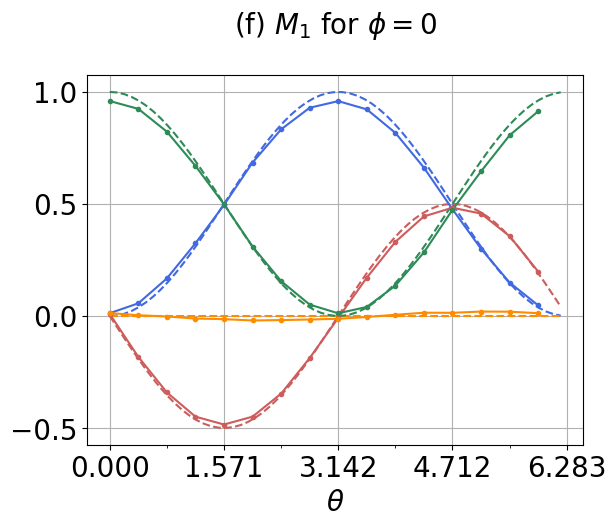

In [132]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
#x-axis
x = np.arange(0,2*np.pi,np.pi/8)
x0 = np.arange(0,2*np.pi,0.1)


#y-axis
y = data3_1

#for i in range(16):
#    y[2][i]=-y[2][i]

yerr = data_sd_3_1

#color
col=['royalblue','indianred','darkorange','seagreen']
#label
lab=[r'$\langle 0| M_0 |0\rangle  $',r'Re$[\langle 0| M_0 |1\rangle]$',r'Im$[\langle 0| M_0 |1\rangle]$',r'$\langle 1| M_0 |1\rangle$']



for i in range(4):
    plt.errorbar(x, y[i] , yerr=yerr[i], label=lab[i], fmt='.',color=col[i])
    

plt.plot(x0, np.sin(x0/2)**2,'--', color=col[0])
plt.plot(x0, -np.cos(x0/2)*np.sin(x0/2),'--', color=col[1])
plt.plot(x0, 0*x0,'--', color=col[2])
plt.plot(x0, np.cos(x0/2)**2,'--', color=col[3])

plt.plot(x, y[0], color=col[0])
plt.plot(x, y[1], color=col[1])
plt.plot(x, y[2], color=col[2])
plt.plot(x, y[3], color=col[3])

plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)

ax.grid(True)
#ax.legend(frameon=False)
# ax.axis('equal')
# ax.set_xlim(0, 2 * np.pi);
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
# ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax.set_xlabel(r'$\theta$',fontsize=20)
ax.set_title(r'(f) $M_1$ for $\phi=0$',fontsize=20,pad=30)

# plt.legend(loc='lower right')

# Coherence of measurement

In [133]:
coh_m1=[]
for i in range(16):
    x=np.sqrt(data1[1][i]**2+data1[2][i]**2)+np.sqrt(data1_1[1][i]**2+data1[2][i]**2)
    coh_m1.append(x)

In [134]:
coh_m2=[]
for i in range(16):
    x=np.sqrt(data2[1][i]**2+data2[2][i]**2)+np.sqrt(data2_1[1][i]**2+data2[2][i]**2)
    coh_m2.append(x)

In [135]:
coh_m3=[]
for i in range(16):
    x=np.sqrt(data3[1][i]**2+data3[2][i]**2)+np.sqrt(data3_1[1][i]**2+data3[2][i]**2)
    coh_m3.append(x)

In [136]:
coh_m=[]
for i in range(16):
    x=np.sqrt(average_total[i][0]['01r']**2+average_total[i][0]['01i']**2)+np.sqrt(average_total[i][1]['01r']**2+average_total[i][1]['01i']**2)
    coh_m.append(x)

<function matplotlib.pyplot.show(close=None, block=None)>

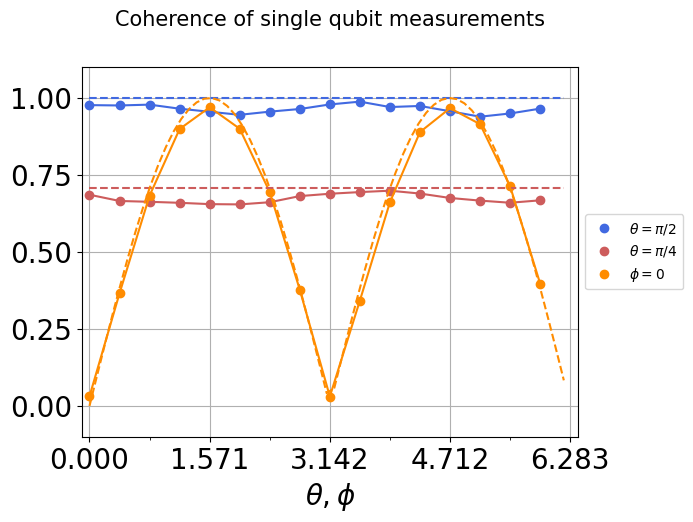

In [138]:
fig, ax = plt.subplots()

x = np.arange(0,2*np.pi,np.pi/8)
x0 = np.arange(0,2*np.pi,0.1)

col=['royalblue','indianred','darkorange','seagreen']
lab=[r'$\theta=\pi/2$',r'$\theta=\pi/4$',r'$\phi=0$']


plt.axis((0,2*np.pi,0,1.2))
#plt.plot(x, coh_m, color=col[0])
plt.plot(x, coh_m1,'o', color=col[0],label=lab[0])
plt.plot(x, coh_m2, 'o', color=col[1],label=lab[1])
plt.plot(x, coh_m3, 'o',color=col[2],label=lab[2])

plt.plot(x, coh_m1, color=col[0])
plt.plot(x, coh_m2, color=col[1])
plt.plot(x, coh_m3,color=col[2])

# plt.plot(x, coh_m1, color=col[0])
# plt.plot(x, coh_m2/(2*np.cos(np.pi/8)*np.sin(np.pi/8)), color=col[1])
# plt.plot(x, coh_m3/(np.abs(2*np.cos(x/2)*np.sin(x/2))),color=col[2])

plt.plot(x0, 0*x0+1 ,'--', color=col[0])
plt.plot(x0, 0*x0+2*np.cos(np.pi/8)*np.sin(np.pi/8),'--', color=col[1])
plt.plot(x0, np.abs(2*np.cos(x0/2)*np.sin(x0/2)),'--', color=col[2])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.grid(True)
ax.legend(frameon=False,loc='center left',bbox_to_anchor=(1, 0.5))
# ax.axis('equal')
# ax.set_xlim(0, 2 * np.pi);
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
# ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax.set_ylim(-0.1, 1.1);
ax.set_xlim(-0.1, 2*np.pi+0.1);

ax.set_xlabel(r'$\theta, \phi$',fontsize=20)
ax.set_title(r'Coherence of single qubit measurements',fontsize=15,pad=30)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))



plt.show

### Qiskit Runtime Sampler

In [21]:
service = QiskitRuntimeService(instance='ibm-q-yonsei/externalq-meetup/tutorials')


In [22]:
backend = service.get_backend('ibm_nairobi')


In [25]:
options = Options(optimization_level=2)
options.execution.shots = 20000

In [26]:
session = Session(backend=backend)

sampler = Sampler(session=session, options=options)

In [27]:
ret_job = service.job('chnaadcpd6rr9jhpfcpg')
ret_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [28]:
res = ret_job.result()
real_prob = [res.quasi_dists[i:i+4] for i in range(0, len(res.quasi_dists[:]),4)]

In [31]:
l=16
average_total=[]
sd_total=[]
for i in range(l):
    average_total.append(ave(det_tomo_POVM0(real_prob[i])))

#len(average_total)
for i in range(l):
    sd_total.append(sta_dis(det_tomo_POVM0(real_prob[i])))

In [32]:
key_POVM=['00','01r','01i','11']
data1=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(average_total[j][0][key_POVM[i]])
    
    data1.append(y)

In [33]:
key_POVM=['00','01r','01i','11']
data_sd1=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(sd_total[j][0][key_POVM[i]])
    
    data_sd1.append(y)

In [34]:
def format_func(value, tick_number):
    # find number of multiples of pi/2
    N = int(np.round(2 * value / np.pi))
    if N == 0:
        return "0"
    elif N == 1:
        return r"$\pi/2$"
    elif N == 2:
        return r"$\pi$"
    elif N % 2 > 0:
        return r"${0}\pi/2$".format(N)
    else:
        return r"${0}\pi$".format(N // 2)

Text(0.5, 1.0, '(a) $M_0$ for $\\theta=\\pi/2$')

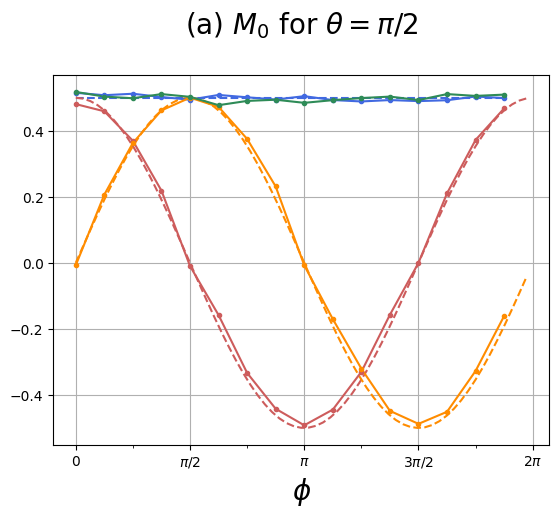

In [35]:
fig, ax = plt.subplots()

#x-axis
x = np.arange(0,2*np.pi,np.pi/8)
x0 = np.arange(0,2*np.pi,0.1)


#y-axis
y = data1

#for i in range(16):
#    y[2][i]=-y[2][i]

yerr = data_sd1

#color
col=['royalblue','indianred','darkorange','seagreen']
#label
lab=[r'$\langle 0| M_0 |0\rangle  $',r'Re$[\langle 0| M_0 |1\rangle]$',r'Im$[\langle 0| M_0 |1\rangle]$',r'$\langle 1| M_0 |1\rangle$']


for i in range(4):
    plt.errorbar(x, y[i] , yerr=yerr[i], label=lab[i], fmt='.',color=col[i])
    
ax.plot(x, 0*x+0.5,'--', color=col[0])
ax.plot(x0, 0.5*np.cos(x0),'--', color=col[1])
ax.plot(x0, 0.5*np.sin(x0),'--', color=col[2])

ax.plot(x, y[0], color=col[0])
ax.plot(x, y[1], color=col[1])
ax.plot(x, y[2], color=col[2])
ax.plot(x, y[3], color=col[3])

plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)

ax.grid(True)
# ax.legend(frameon=False)
# ax.axis('equal')
# ax.set_xlim(0, 2 * np.pi);
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax.set_xlabel(r'$\phi$',fontsize=20)
ax.set_title(r'(a) $M_0$ for $\theta=\pi/2$',fontsize=20,pad=30)

#plt.legend(loc='lower right')

In [36]:
key_POVM=['00','01r','01i','11']
data1_1=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(average_total[j][1][key_POVM[i]])
    
    data1_1.append(y)
    
key_POVM=['00','01r','01i','11']
data_sd1_1=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(sd_total[j][1][key_POVM[i]])
    
    data_sd1_1.append(y)

Text(0.5, 1.0, '(b) $M_1$ for $\\theta=\\pi/2$')

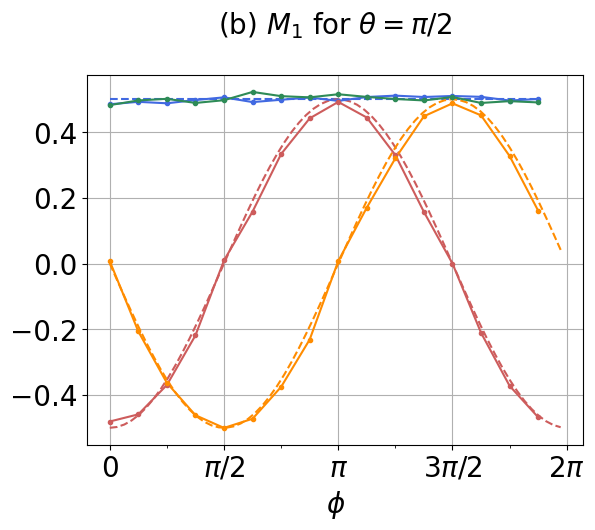

In [37]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
#x-axis
x = np.arange(0,2*np.pi,np.pi/8)
x0 = np.arange(0,2*np.pi,0.1)


#y-axis
y = data1_1

#for i in range(16):
#    y[2][i]=-y[2][i]

yerr = data_sd1_1

#color
col=['royalblue','indianred','darkorange','seagreen']
#label
lab=[r'$\langle 0| M_0 |0\rangle  $',r'Re$[\langle 0| M_0 |1\rangle]$',r'Im$[\langle 0| M_0 |1\rangle]$',r'$\langle 1| M_0 |1\rangle$']



for i in range(4):
    plt.errorbar(x, y[i] , yerr=yerr[i], label=lab[i], fmt='.',color=col[i])
    

plt.plot(x, 0*x+0.5,'--', color=col[0])
plt.plot(x0, -0.5*np.cos(x0),'--', color=col[1])
plt.plot(x0, -0.5*np.sin(x0),'--', color=col[2])

plt.plot(x, y[0], color=col[0])
plt.plot(x, y[1], color=col[1])
plt.plot(x, y[2], color=col[2])
plt.plot(x, y[3], color=col[3])

plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)

ax.grid(True)
#ax.legend(frameon=False)
# ax.axis('equal')
# ax.set_xlim(0, 2 * np.pi);
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax.set_xlabel(r'$\phi$',fontsize=20)
ax.set_title(r'(b) $M_1$ for $\theta=\pi/2$',fontsize=20,pad=30)

#plt.legend(loc='lower right')

## $\theta=\pi/4$ and  $\phi=0,\pi/8,\pi/4,...,15\pi/6$
Each job is excuted with 100000 shots

In [38]:
#bring tomo_circ
circ = d_tomo_circ()

#set-up variable range
theta_range = np.linspace(0, 2 * np.pi - np.pi/8, 16)

#loop theta value
    #loop tomo circ circ 0 ~ 3 with same theta value
circuits = [qc.bind_parameters([np.pi/4, phi])
            for phi in theta_range for qc in circ]


In [40]:
session = Session(backend=backend)

sampler = Sampler(session=session, options=options)

In [41]:
job2 = sampler.run(circuits)

In [49]:
ret_job = service.job('chnap6inajhpa63k4oeg')
ret_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [50]:
res = ret_job.result()
real_prob2 = [res.quasi_dists[i:i+4] for i in range(0, len(res.quasi_dists[:]),4)]

In [51]:
l=16
average_total=[]
sd_total=[]
for i in range(l):
    average_total.append(ave(det_tomo_POVM0(real_prob2[i])))

#len(average_total)
for i in range(l):
    sd_total.append(sta_dis(det_tomo_POVM0(real_prob2[i])))

In [52]:
key_POVM=['00','01r','01i','11']
data2=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(average_total[j][0][key_POVM[i]])
    
    data2.append(y)

In [53]:
key_POVM=['00','01r','01i','11']
data_sd2=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(sd_total[j][0][key_POVM[i]])
    
    data_sd2.append(y)

Text(0.5, 1.0, '(c) $M_0$ for $\\theta=\\pi/4$')

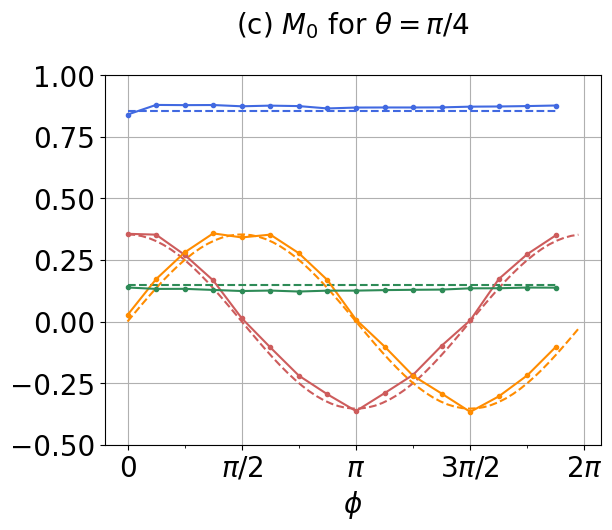

In [54]:
fig, ax = plt.subplots()
#x-axis
x = np.arange(0,2*np.pi,np.pi/8)
x0 = np.arange(0,2*np.pi,0.1)


#y-axis
y = data2

#for i in range(16):
#    y[2][i]=-y[2][i]

yerr = data_sd2

#color
col=['royalblue','indianred','darkorange','seagreen']

#label
lab=['0','01r','01i','1']

for i in range(4):
    plt.errorbar(x, y[i] , yerr=yerr[i], label=lab[i], fmt='.',color=col[i])
    

plt.plot(x, 0*x+np.cos(np.pi/8)**2,'--', color=col[0])
plt.plot(x0, np.cos(np.pi/8)*np.sin(np.pi/8)*np.cos(x0),'--', color=col[1])
plt.plot(x0, np.cos(np.pi/8)*np.sin(np.pi/8)*np.sin(x0),'--', color=col[2])
plt.plot(x, 0*x+np.sin(np.pi/8)**2,'--', color=col[3])

plt.plot(x, y[0], color=col[0])
plt.plot(x, y[1], color=col[1])
plt.plot(x, y[2], color=col[2])
plt.plot(x, y[3], color=col[3])

plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)

ax.grid(True)
#ax.legend(frameon=False)
# ax.axis('equal')
# ax.set_xlim(0, 2 * np.pi);
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax.set_ylim(-0.5, 1);

ax.set_xlabel(r'$\phi$',fontsize=20)
ax.set_title(r'(c) $M_0$ for $\theta=\pi/4$',fontsize=20,pad=30)

In [55]:
key_POVM=['00','01r','01i','11']
data2_1=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(average_total[j][1][key_POVM[i]])
    
    data2_1.append(y)

In [56]:
key_POVM=['00','01r','01i','11']
data_sd2_1=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(sd_total[j][1][key_POVM[i]])
    
    data_sd2_1.append(y)

Text(0.5, 1.0, '(d) $M_1$ for $\\theta=\\pi/4$')

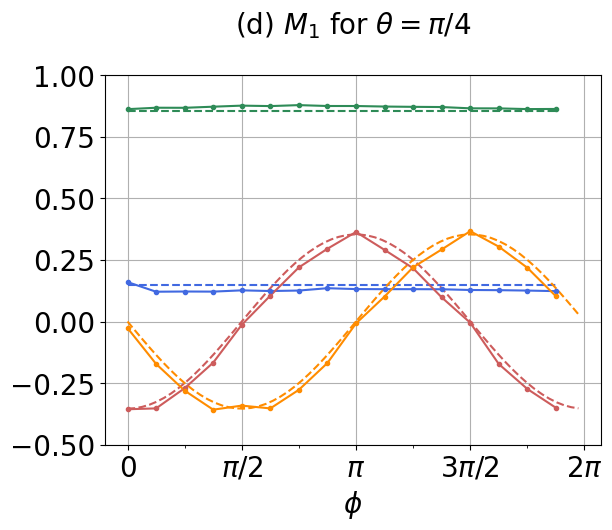

In [57]:
fig, ax = plt.subplots()
#x-axis
x = np.arange(0,2*np.pi,np.pi/8)
x0 = np.arange(0,2*np.pi,0.1)


#y-axis
y = data2_1

#for i in range(16):
#    y[2][i]=-y[2][i]

yerr = data_sd2_1

#color
col=['royalblue','indianred','darkorange','seagreen']

#label
lab=['0','01r','01i','1']

for i in range(4):
    plt.errorbar(x, y[i] , yerr=yerr[i], label=lab[i], fmt='.',color=col[i])
    


plt.plot(x,0*x+np.sin(np.pi/8)**2 ,'--', color=col[0])
plt.plot(x0, -np.cos(np.pi/8)*np.sin(np.pi/8)*np.cos(x0),'--', color=col[1])
plt.plot(x0, -np.cos(np.pi/8)*np.sin(np.pi/8)*np.sin(x0),'--', color=col[2])
plt.plot(x, 0*x+np.cos(np.pi/8)**2,'--', color=col[3])

plt.plot(x, y[0], color=col[0])
plt.plot(x, y[1], color=col[1])
plt.plot(x, y[2], color=col[2])
plt.plot(x, y[3], color=col[3])

ax.grid(True)
#ax.legend(frameon=False)
# ax.axis('equal')
# ax.set_xlim(0, 2 * np.pi);
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax.set_ylim(-0.5, 1);

ax.set_xlabel(r'$\phi$',fontsize=20)
ax.set_title(r'(d) $M_1$ for $\theta=\pi/4$',fontsize=20,pad=30)

#plt.legend(loc='lower right')

## $\phi=0$ and  $\theta=0,\pi/8,\pi/4,...,15\pi/8,2\pi$
Each job is excuted with 100000 shots 

In [58]:
#bring tomo_circ
circ = d_tomo_circ()

#set-up variable range
theta_range = np.linspace(0, 2 * np.pi - np.pi/8, 16)

#loop theta value
    #loop tomo circ circ 0 ~ 3 with same theta value
circuits = [qc.bind_parameters([phi, 0])
            for phi in theta_range for qc in circ]

In [59]:
job3 = sampler.run(circuits)
job3.job_id()

'chnav842b9sdqn1ggqbg'

In [65]:
ret_job = service.job('chnav842b9sdqn1ggqbg')
ret_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [66]:
res = ret_job.result()
real_prob3 = [res.quasi_dists[i:i+4] for i in range(0, len(res.quasi_dists[:]),4)]

In [67]:
l=16
average_total=[]
sd_total=[]
for i in range(l):
    average_total.append(ave(det_tomo_POVM0(real_prob3[i])))

#len(average_total)
for i in range(l):
    sd_total.append(sta_dis(det_tomo_POVM0(real_prob3[i])))

In [68]:
key_POVM=['00','01r','01i','11']
data3=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(average_total[j][0][key_POVM[i]])
    
    data3.append(y)
    
    
key_POVM=['00','01r','01i','11']
data_sd3=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(sd_total[j][0][key_POVM[i]])
    
    data_sd3.append(y)

NameError: name 'data3' is not defined

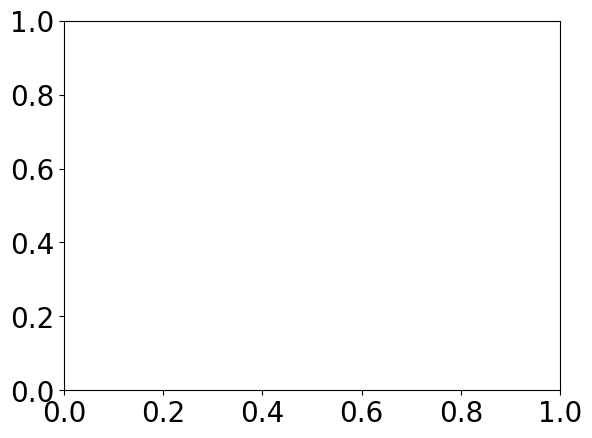

In [75]:
fig, ax = plt.subplots()
#x-axis
x = np.arange(0,2*np.pi,np.pi/8)
x0 = np.arange(0,2*np.pi,0.1)


#y-axis
y = data3

#for i in range(16):
#    y[2][i]=-y[2][i]

yerr = data_sd3

#color
col=['royalblue','indianred','darkorange','seagreen']

#label
lab=[r'$\langle 0| M_0 |0\rangle $',r'Re$[\langle 0| M_0 |1\rangle]$',r'Im$[\langle 0| M_0 |1\rangle]$',r'$\langle 1| M_0 |1\rangle$']

for i in range(4):
    plt.errorbar(x, y[i] , yerr=yerr[i], label=lab[i], fmt='.',color=col[i])
    

plt.plot(x0, np.cos(x0/2)**2,'--', color=col[0])
plt.plot(x0, np.cos(x0/2)*np.sin(x0/2),'--', color=col[1])
plt.plot(x0, 0*x0,'--', color=col[2])
plt.plot(x0, np.sin(x0/2)**2,'--', color=col[3])

plt.plot(x, y[0], color=col[0])
plt.plot(x, y[1], color=col[1])
plt.plot(x, y[2], color=col[2])
plt.plot(x, y[3], color=col[3])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.grid(True)
ax.legend(frameon=False,loc='center left',bbox_to_anchor=(1, 0.5))
# ax.axis('equal')
# ax.set_xlim(0, 2 * np.pi);
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax.set_ylim(-0.6, 1.1);

ax.set_xlabel(r'$\theta$',fontsize=20)
ax.set_title(r'(e) $M_0$ for $\phi=\pi/4$',fontsize=20,pad=30)

#plt.legend(loc='upper right')

In [72]:
key_POVM=['00','01r','01i','11']
data3_1=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(average_total[j][1][key_POVM[i]])
    
    data3_1.append(y)
    
key_POVM=['00','01r','01i','11']
data_sd3_1=[]
for i in range(4):
    y=[]
    for j in range(16):
        y.append(sd_total[j][1][key_POVM[i]])
    
    data_sd3_1.append(y)

NameError: name 'data3_1' is not defined

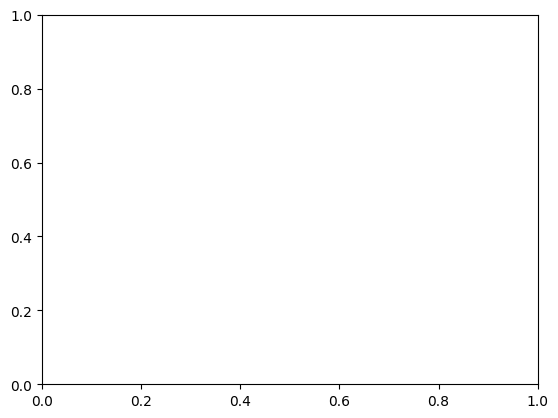

In [60]:
fig, ax = plt.subplots()
#x-axis
x = np.arange(0,2*np.pi,np.pi/8)
x0 = np.arange(0,2*np.pi,0.1)


#y-axis
y = data3_1

#for i in range(16):
#    y[2][i]=-y[2][i]

yerr = data_sd3_1

#color
col=['royalblue','indianred','darkorange','seagreen']

#label
lab=[r'$\langle 0| M_1 |0\rangle $',r'Re$[\langle 0| M_1 |1\rangle]$',r'Im$[\langle 0| M_1 |1\rangle]$',r'$\langle 1| M_1 |1\rangle$']


for i in range(4):
    plt.errorbar(x, y[i] , yerr=yerr[i], label=lab[i], fmt='.',color=col[i])
    

plt.plot(x0, np.sin(x0/2)**2,'--', color=col[0])
plt.plot(x0, -np.cos(x0/2)*np.sin(x0/2),'--', color=col[1])
plt.plot(x0, 0*x0,'--', color=col[2])
plt.plot(x0, np.cos(x0/2)**2,'--', color=col[3])

plt.plot(x, y[0], color=col[0])
plt.plot(x, y[1], color=col[1])
plt.plot(x, y[2], color=col[2])
plt.plot(x, y[3], color=col[3])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.grid(True)
ax.legend(frameon=False,loc='center left',bbox_to_anchor=(1, 0.5))
# ax.axis('equal')
# ax.set_xlim(0, 2 * np.pi);
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax.set_ylim(-0.6, 1.1);

ax.set_xlabel(r'$\theta$',fontsize=20)
ax.set_title(r'(f) $M_1$ for $\phi=\pi/4$',fontsize=20,pad=30)

#plt.legend(loc='upper right')

# Coherence of measurement

In [74]:
coh_m1=[]
for i in range(16):
    x=np.sqrt(data1[1][i]**2+data1[2][i]**2)+np.sqrt(data1_1[1][i]**2+data1[2][i]**2)
    coh_m1.append(x)

In [75]:
coh_m2=[]
for i in range(16):
    x=np.sqrt(data2[1][i]**2+data2[2][i]**2)+np.sqrt(data2_1[1][i]**2+data2[2][i]**2)
    coh_m2.append(x)

In [76]:
coh_m3=[]
for i in range(16):
    x=np.sqrt(data3[1][i]**2+data3[2][i]**2)+np.sqrt(data3_1[1][i]**2+data3[2][i]**2)
    coh_m3.append(x)

In [77]:
coh_m=[]
for i in range(16):
    x=np.sqrt(average_total[i][0]['01r']**2+average_total[i][0]['01i']**2)+np.sqrt(average_total[i][1]['01r']**2+average_total[i][1]['01i']**2)
    coh_m.append(x)

<function matplotlib.pyplot.show(close=None, block=None)>

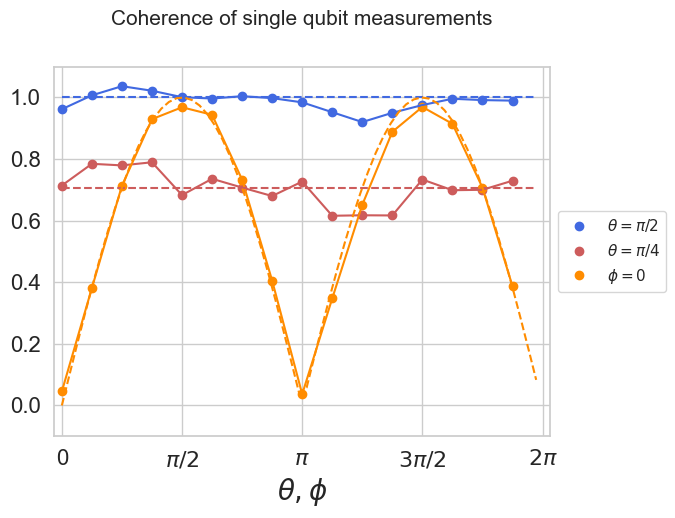

In [84]:
fig, ax = plt.subplots()

x = np.arange(0,2*np.pi,np.pi/8)
x0 = np.arange(0,2*np.pi,0.1)

col=['royalblue','indianred','darkorange','seagreen']
lab=[r'$\theta=\pi/2$',r'$\theta=\pi/4$',r'$\phi=0$']


plt.axis((0,2*np.pi,0,1.2))
#plt.plot(x, coh_m, color=col[0])
plt.plot(x, coh_m1,'o', color=col[0],label=lab[0])
plt.plot(x, coh_m2, 'o', color=col[1],label=lab[1])
plt.plot(x, coh_m3, 'o',color=col[2],label=lab[2])

plt.plot(x, coh_m1, color=col[0])
plt.plot(x, coh_m2, color=col[1])
plt.plot(x, coh_m3,color=col[2])

# plt.plot(x, coh_m1, color=col[0])
# plt.plot(x, coh_m2/(2*np.cos(np.pi/8)*np.sin(np.pi/8)), color=col[1])
# plt.plot(x, coh_m3/(np.abs(2*np.cos(x/2)*np.sin(x/2))),color=col[2])

plt.plot(x0, 0*x0+1 ,'--', color=col[0])
plt.plot(x0, 0*x0+2*np.cos(np.pi/8)*np.sin(np.pi/8),'--', color=col[1])
plt.plot(x0, np.abs(2*np.cos(x0/2)*np.sin(x0/2)),'--', color=col[2])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.grid(True)
ax.legend(frameon=False,loc='center left',bbox_to_anchor=(1, 0.5))
# ax.axis('equal')
# ax.set_xlim(0, 2 * np.pi);
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax.set_ylim(-0.1, 1.1);
ax.set_xlim(-0.1, 2*np.pi+0.1);

ax.set_xlabel(r'$\theta, \phi$',fontsize=20)
ax.set_title(r'Coherence of single qubit measurements',fontsize=15,pad=30)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))



plt.show

In [140]:
coh_m=[coh_m1,coh_m2,coh_m3]
x = np.arange(0,2*np.pi,np.pi/8)

errorrate_total=[]


for j in range(len(coh_m)):
    errorrate=[]
    
    if j==0:
        
        for i in range(len(coh_m1)):
            errorrate.append(coh_m1[i])

        errorrate_total.append(errorrate)
        
    elif j==1:
        for i in range(len(coh_m2)):
            errorrate.append(coh_m2[i]/(2*np.cos(np.pi/8)*np.sin(np.pi/8)))
        errorrate_total.append(errorrate)    
        
    elif j==2:
        for i in range(len(coh_m3)):
            if x[i]==0 or x[i]==np.pi or x[i]==2*np.pi:
                pass
            else:
                errorrate.append(coh_m3[i]/(np.abs(2*np.cos(x[i]/2)*np.sin(x[i]/2))))

        errorrate_total.append(errorrate)

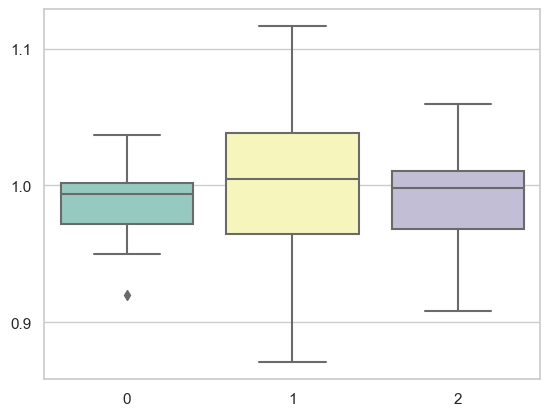

In [80]:
import seaborn as sns
sns.set(style="whitegrid")
colors=['royalblue','indianred','darkorange','seagreen']
labels=[r'1.$\theta=\pi/2$',r'2.$\theta=\pi/4$',r'3.$\phi=0$']
tips = labels
ax = sns.boxplot(#x=labels,
                 data=[errorrate_total[0],errorrate_total[1],errorrate_total[2]],color='0.1',palette="Set3")

#####################
from matplotlib import rcParams

labelsize = 25
rcParams['xtick.labelsize'] = labelsize
rcParams['ytick.labelsize'] = labelsize 
#####################

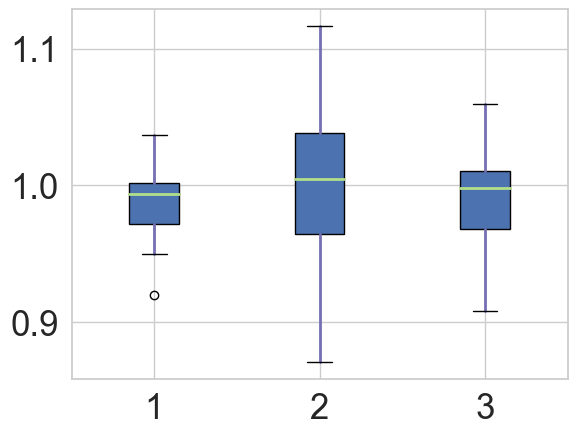

In [81]:
bp = plt.boxplot([errorrate_total[0],errorrate_total[1],errorrate_total[2]], patch_artist=True)
colors=['royalblue','indianred','darkorange','seagreen']
for median in bp["medians"]:
   median.set(color="#b2df8a", linewidth=2)
for whisker in bp["whiskers"]:
   whisker.set(color="#7570b3", linewidth=2)

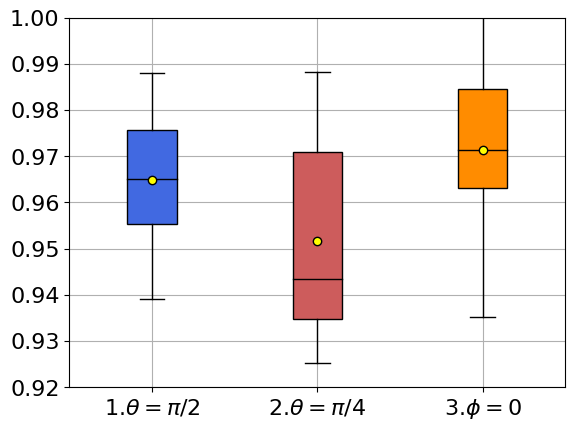

In [142]:
fig, ax = plt.subplots()
labels=[r'1.$\theta=\pi/2$',r'2.$\theta=\pi/4$',r'3.$\phi=0$']
colors=['royalblue','indianred','darkorange','seagreen']
box = ax.boxplot([errorrate_total[0],errorrate_total[1],errorrate_total[2]],
           vert=True,
           notch=False,
           labels=labels,
           patch_artist=True,
            showmeans=True,
            meanprops={"marker":"o","markerfacecolor":"yellow", "markeredgecolor":"black"},
            medianprops={'color':'black'}
           #color=colors
          )
ax.set_ylim(0.92, 1);
ax.grid(True)
#patch.set_facecolor(colors)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    



#####################
from matplotlib import rcParams

labelsize = 16
rcParams['xtick.labelsize'] = labelsize
rcParams['ytick.labelsize'] = labelsize 
#####################

plt.show()